* Student name: Rachel Edwards, Svitlana Glibova, Marcos Panyagua
* Student pace: full time
* Scheduled project review date/time: 1/29/2021 at 1:00 PM PST
* Instructor name: Max Barry
* Blog post URL:


# Movie Data Analysis

### Business Problem 
Microsoft sees all the big companies creating original video content and they want to get in on the fun. They have decided to create a new movie studio, but they don’t know anything about creating movies. You are charged with exploring what types of films are currently doing the best at the box office. You must then translate those findings into actionable insights that the head of Microsoft's new movie studio can use to help decide what type of films to create.

## Business Understanding

In order to generate actionable insights for this stakeholder, we are inspecting several data sets containing film information.  


### Sources:  
-[Box Office Mojo](https://www.boxofficemojo.com/)  
-[IMDB](https://www.imdb.com/)  
-[Rotten Tomatoes](https://www.rottentomatoes.com/)  
-[The Movie DB](https://www.themoviedb.org/)  
-[The Numbers](https://www.the-numbers.com/)   

### Topics to address:  
- Which producers create the best films?  
    - Criteria for analysis:  
        - Production budget vs. gross income
        - Mean of film (review) ratings over time
        - Success of particular genres of films per producer
        
- Which film genres are most successful in theaters?  
    - Criteria for analysis:  
        - Gross income of particular genres of films  
        - The associated production costs of particular genres
        - Success of particular film (classification) ratings  
        
- Is there a season during which film releases fare better?  
    - Criteria for analysis:  
        - Frequency of films being released over quarters and months  
        - Gross income of films grouped over quarters and months  
        - Production costs for films being released during the most profitable months

### Possible measurements of success:  
- Net income: gross income minus production budget
- Worldwide gross income
- Viewership numbers
- Film ratings

### 

## Data Preparation

In [316]:
import gzip
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import datetime
import copy
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [317]:
basics_names = pd.read_csv("zippedData/imdb.name.basics.csv")
#Nconst, Primary Name, Primary Profession, Known for titles(title_id)
#just producers
ratings = pd.read_csv("zippedData/imdb.title.ratings.csv")
#Tconst, Average Rating, Number of Votes
movies_gross = pd.read_csv("zippedData/bom.movie_gross.csv")
#Titles, Studio, Domestic Gross, Foreign Gross and Year
basics_titles = pd.read_csv("zippedData/imdb.title.basics.csv")
#Tconst, Primary Title, Original Title, Start Year, Runtime Minutes, Genres
movie_budgets = pd.read_csv("zippedData/tn.movie_budgets.csv")
movie_budgets = pd.read_csv("zippedData/tn.movie_budgets.csv")
#Id, Release Date, Movie Name, Production Budget, Domestic Gross, Worldwide Gross
movies = pd.read_csv("zippedData/tmdb.movies.csv")
#Genre Id, Id, Original Language, Original Language, Original Title, Popularity, Release Date, Title, Vote Average, Vote count

# Working with data

### Working with the basics_titles dataframe

Creating a table that contains Titles, Genres, Start Year and Tconst.

In [318]:
# Clean basics_titles to only those released after 2008 and before 2020
# Clean NAN rows, since they didn't have the most important information for this analysis, the genre
# Drop the columns

basics_titles = basics_titles[basics_titles['start_year'] > 2008]
basics_titles = basics_titles[basics_titles['start_year'] <= 2019]
title_genre = basics_titles.drop(['original_title', 'runtime_minutes'], axis=1)
title_genre.dropna(inplace=True)

Creating a new table with the rating, tconst, primary_title and genre.

In [320]:
# Join tables to create a new one with more info
# Drop NAN values, since they didn't have the most important information for this analysis, the genre

titlegenrerating = ratings.join(title_genre.set_index('tconst'), on='tconst')
titlegenrerating.dropna(inplace=True)
titlegenrerating.rename(columns={"start_year": "release_year"}, inplace=True)

# Working with the movie_budgets dataframe

The goal here is to create a table with Movies Name, Budget, Domestic Gross and Worldwide Gross(Cleaning the column ID)

In [322]:
# Drop columns that we are not going to use
# Rename Column to match the other table, to make left-join possible

movies_money = movie_budgets.drop(['id', 'release_date'], axis=1)
movies_money.rename(columns={"movie": "primary_title"}, inplace=True)

In [323]:
# Using method str.replace to remove ',' and '$' from the data columns 
# Using astype to change the values in those columns from String to Float because to Int gives an error

movies_money['worldwide_gross'] = movies_money['worldwide_gross'].str.replace(',', '')
movies_money['worldwide_gross'] = movies_money['worldwide_gross'].str.replace('$', '')
movies_money['worldwide_gross'] = movies_money['worldwide_gross'].astype(float)

movies_money['production_budget'] = movies_money['production_budget'].str.replace(',', '')
movies_money['production_budget'] = movies_money['production_budget'].str.replace('$', '')
movies_money['production_budget'] = movies_money['production_budget'].astype(float)

movies_money['domestic_gross'] = movies_money['domestic_gross'].str.replace(',', '')
movies_money['domestic_gross'] = movies_money['domestic_gross'].str.replace('$', '')
movies_money['domestic_gross'] = movies_money['domestic_gross'].astype(float)


In [324]:
# Create a new column to give the investment return (How many dollars you get per dollar invested)
# Check for duplicated entries on the data based on the primary title column q
# Drop all the duplicates, not keeping any so it doesn't conflict with the other table and we get false information

movies_money['investment_return'] = movies_money['worldwide_gross']/movies_money['production_budget'] -1 

duplicates_money = movies_money[movies_money.duplicated(subset=['primary_title'],keep=False)].sort_values(['primary_title'])

movies_money.drop_duplicates(subset='primary_title', inplace=True)

# Creating the new table moviesfullinfo

The idea here is to join two tables to make one with ratings and money to make mostly a correlation between these 2 metrics

In [325]:
# Drop Tconst, since this one is supposed to be the final table to use for graphs
# Drop nan's values
# Creat a filter to only movies that had a budget over a million dollars

moviesfullinfo = movies_money.join(titlegenrerating.set_index('primary_title'), on='primary_title')
moviesfullinfo.drop(['tconst', 'numvotes', 'domestic_gross'], axis=1, inplace=True)
moviesfullinfo = moviesfullinfo.dropna()
moviesfullinfo = moviesfullinfo[moviesfullinfo['production_budget'] >= 1000000]
moviesfullinfo = moviesfullinfo[moviesfullinfo['worldwide_gross'] >= 1]
moviesfullinfo.drop_duplicates(subset='primary_title', inplace=True)

# Creating the new table movieswoutratings

Here the goal was to make a table to make a correlation between Genre, Production, Worldwide Gross, Domestic Gross and ROI's

In [326]:
# Clean any NAN values
# Create filter to production budget over 1 million dollars
# Create filter where the movie made at least 1 dollar (Excluding movies from streaming services)

movieswoutratings = moviesfullinfo.dropna()
movieswoutratings = movieswoutratings[movieswoutratings['production_budget'] >= 1000000]
movieswoutratings = movieswoutratings[movieswoutratings['worldwide_gross'] >= 1]

# Making tables for each genre

>Made a list with all the genres in it!

In [327]:
listatest = []
generos = "Action, Adventure, Animation, Biography, Crime, Documentary, Drama, Family, Fantasy, History, Horror, Music, Musical, Mystery, Romance, Sci-fi, Sport, Thriller, War, Western"
listatest.append(generos.split(", "))
listatest = listatest[0]

>Created a table for each genre, so it's easier to see and manipulate

In [328]:
def get_df_genre(genre):
    '''
    This function gets a dataset based on the Genre, with the average rating attached to it
    '''
    return titlegenrerating[titlegenrerating['genres'].str.contains(genre.title().strip())]

In [329]:
genre_rating_df = []
for genre in listatest:
    genre_rating_df.append(get_df_genre(genre))
    

>And here we create a table for each genre with important info attached, but for that we had to lose some rows.

In [331]:
def get_df_genre(genre):
    '''
    This function gets a dataset based on the Genre, with information
    like production buddget and worldwide gross attached to it.
    '''
    return moviesfullinfo[moviesfullinfo['genres'].str.contains(genre.title().strip())]

In [332]:
all_genre_df = []
for genre in listatest:
    all_genre_df.append(get_df_genre(genre))
    

>And now we want the average rating based on the genre! Is there one that is more likely to be acclaimed by critics?

Getting the average RATING per Genre

In [334]:
def avg_rating_genre(dataframe):
    '''
    This function gets the avarage(mean) rating based on the Genre
    '''
    return(dataframe['averagerating'].mean())

In [335]:
avg_rating_per_genre = []
for rating in genre_rating_df:
    avg_rating_per_genre.append(avg_rating_genre(rating))

**Getting the average RETURN ON INVESTMENT per Genre**

In [339]:
def avg_roi_genre(dataframe):
    '''
    This function gets the ROI based on the Genre
    '''
    worldgross = sum(dataframe['worldwide_gross'])
    prodbudget = sum(dataframe['production_budget'])
    #print(prodbudget)
    return (worldgross/prodbudget-1)*100

In [340]:
avg_roi_per_genre = []
for genre_df in all_genre_df:
    avg_roi_per_genre.append(avg_roi_genre(genre_df))

# Data Visualization
## Rating per genre
- How likely is to have a better rating with the critics if your movie is a certain genre?

> **To answer that we use "genre_rating_df" table that we prepared for this topic!**

In [341]:
df1 = pd.DataFrame({"Avg. Rating":avg_rating_per_genre, "Genres":listatest})

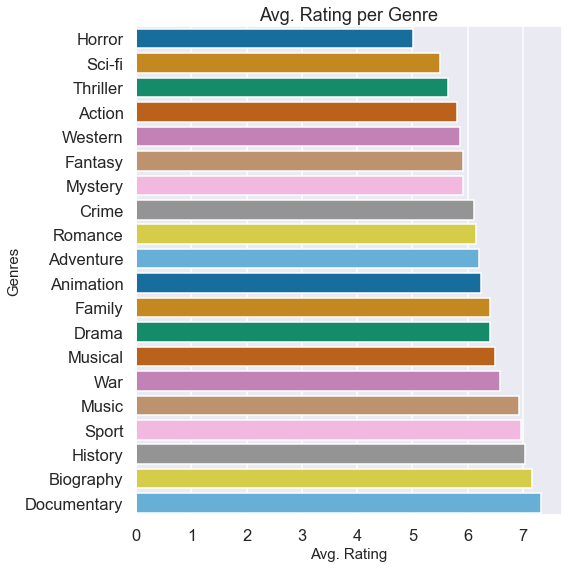

In [342]:
plt.figure(figsize=(8,8))
sns.barplot(x="Avg. Rating", y = "Genres", palette='colorblind', data=df1, errcolor='.95', order=df1.sort_values("Avg. Rating").Genres)
plt.xlabel("Avg. Rating", size=15)
plt.ylabel("Genres", size=15)
plt.title("Avg. Rating per Genre", size=18)
plt.tight_layout()
plt.savefig("barplot_Seaborn_Python.png", dpi=100)

## Money per genre
- What is the best genre solely focused on how much money you can make?
- What genre is the "safest choice"? Less likely to lose money?
- What genre takes the least money to produce? And the most?


### - What is the best genre solely focused on how much money you can make?

In [343]:
df = pd.DataFrame({"ROI":avg_roi_per_genre, "Genres":listatest})

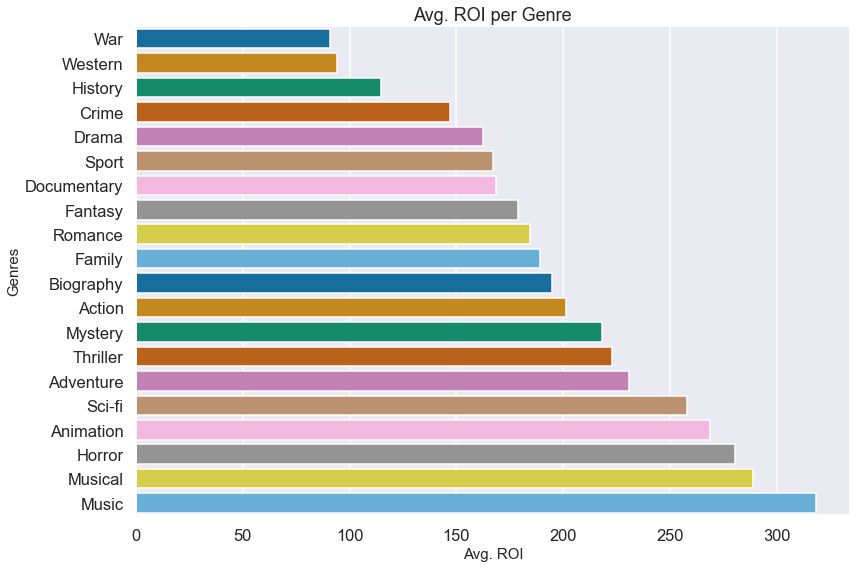

In [344]:
plt.figure(figsize=(12,8))
sns.barplot(x="ROI", y = "Genres", palette=('colorblind'),data=df, order=df.sort_values('ROI').Genres)
plt.xlabel("Avg. ROI", size=15)
plt.ylabel("Genres", size=15)
plt.title("Avg. ROI per Genre", size=18)
plt.tight_layout()
plt.savefig("barplot_Seaborn_Python.png", dpi=100)

The answer? Music, Musical and Horror!

### - What genre is the safest choice?

So we are going to create a list that gives you a percentage of how likely you are to make or to lose money using the number of positive ROI's and the number of negative ROI's.

In [345]:
def how_safe(dataframe):
    '''
    This function gets the avarage(mean) rating based on the Genre
    '''
    positive_count = None
    negative_count = None
    if (dataframe['investment_return'] >= 0).bool():
        positive_count += 1
        total_count += 1
    else:
        total_count += 1
    
    return(positive_count/total_count)

In [346]:
roi_list = []
for roi in all_genre_df:
    roi_list.append(roi['investment_return'])

In [348]:
positive_value = 0
total_value = 0
for x in roi_list[19]:
    if x > 0:
        positive_value += 1
        total_value += 1
    else:
        total_value += 1

In [349]:
chance_of_doing_well = [0.7368421052631579, 0.8174807197943444, 0.8632478632478633, 0.630057803468208, 0.6073825503355704, 0.6785714285714286, 0.6232006773920407, 0.7876106194690266, 0.7910447761194029, 0.5909090909090909, 0.6846153846153846, 0.6301369863013698, 0.4, 0.7159763313609467, 0.6814814814814815, 0.7375, 0.6041666666666666, 0.6675324675324675, 0.43, 0.38461538461538464]

In [350]:
chance_profitability = []
for x in chance_of_doing_well:
        chance_profitability.append(x*100)

In [352]:
chance_loss = []
for loss in chance_profitability:
    chance_loss.append(100-loss)

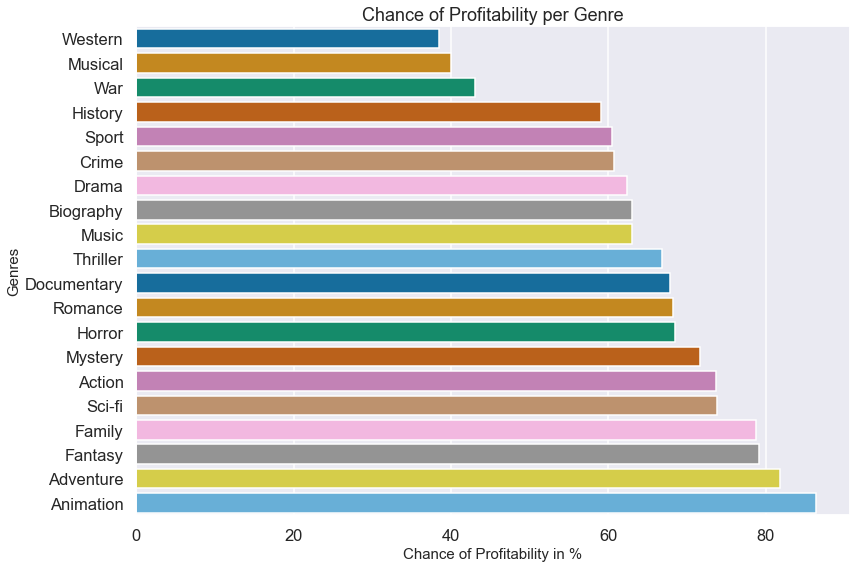

In [353]:
df2 = pd.DataFrame({"Chances":chance_profitability, "Genres":listatest})

plt.figure(figsize=(12,8))
sns.barplot(x="Chances", y = "Genres",data=df2, palette='colorblind', order=df2.sort_values('Chances').Genres)
plt.xlabel("Chance of Profitability in %", size=15)
plt.ylabel("Genres", size=15)
plt.title("Chance of Profitability per Genre", size=18)
plt.tight_layout()
plt.savefig("barplot_Seaborn_Python.png", dpi=100)

<AxesSubplot:title={'center':'Chance of Profitability per Genre'}, ylabel='Genre'>

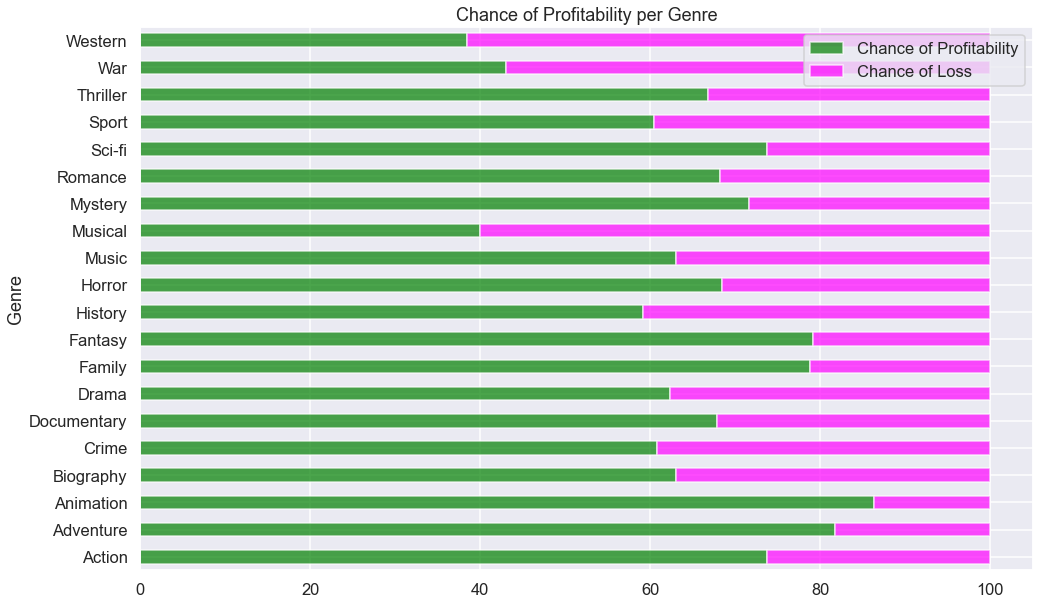

In [354]:
df3 = pd.DataFrame(list(zip(chance_profitability, chance_loss, listatest)), columns =['Chance of Profitability', 'Chance of Loss', 'Genre'])
                   
colors = ['green', 'magenta']
df3.plot( 
    x = 'Genre', 
    kind = 'barh', 
    stacked = True, 
    title = 'Chance of Profitability per Genre',
    mark_right = True,
    color = colors,
    alpha = 0.7,
    figsize=(16,10)) 

## RACHEL

## Data Understanding

# Trimming Down Data
I poked around in the data some more and found a way to link the four big dataframes with all the information I neeeded by merging on their shared content, dropping unused columns, data cleaning, and renaming columns for clarity. I kept a record of the number of columns and rows to asee how much data I lost and make sure it was only things I meant to lose
 My four data frames I used were:
 Basics_names, basics_titles, ratings, movie_budgets

In [355]:
producer = (basics_names.loc[basics_names['primary_profession'] == 'producer'])
#finds only information where the primary profession is equal to producer
#save that data frame in in variable called producer 

producer = producer[producer['known_for_titles'].notna()]
#filters out every NAN in the known for titles column
#only wnat producers who have worked on product
#21492 rows × 6 columns

producer_condensed = producer[['primary_name', 'known_for_titles']]
#condenses down the dataframe to just the infor I want, the two columns with name and titles
#21492 rows × 2 columns

producer_condensed = producer_condensed.rename(columns={'primary_name' : 'producer_name', 'known_for_titles' : 'all_title_ids_unsplit'})
#rename columns for ease of understanding
#21492 rows × 2 columns

producer_condensed['title_id_split']=producer_condensed['all_title_ids_unsplit'].map(lambda x : x.split(','))
#takes the list that contains a single string of comma separated values and separates them so they are iterable
#21492 rows × 3 columns

producer_name_split_title_ids = producer_condensed[['producer_name', 'title_id_split']]
#drops unusable column of unsplit tile ids
#21492 rows × 2 columns

#producer
#producer_condensed
#producer_name_split_title_ids

# Trimming Down Data
I poked around in the data some more and found a way to link the four big dataframes with all the information I neeeded by merging on their shared content, dropping unused columns, data cleaning, and renaming columns for clarity. I kept a record of the number of columns and rows to asee how much data I lost and make sure it was only things I meant to lose
 My four data frames I used were:
 Basics_names, basics_titles, ratings, movie_budgets

In [356]:
producer = (basics_names.loc[basics_names['primary_profession'] == 'producer'])
#finds only information where the primary profession is equal to producer
#save that data frame in in variable called producer 

producer = producer[producer['known_for_titles'].notna()]
#filters out every NAN in the known for titles column
#only wnat producers who have worked on product
#21492 rows × 6 columns

producer_condensed = producer[['primary_name', 'known_for_titles']]
#condenses down the dataframe to just the infor I want, the two columns with name and titles
#21492 rows × 2 columns

producer_condensed = producer_condensed.rename(columns={'primary_name' : 'producer_name', 'known_for_titles' : 'all_title_ids_unsplit'})
#rename columns for ease of understanding
#21492 rows × 2 columns

producer_condensed['title_id_split']=producer_condensed['all_title_ids_unsplit'].map(lambda x : x.split(','))
#takes the list that contains a single string of comma separated values and separates them so they are iterable
#21492 rows × 3 columns

producer_name_split_title_ids = producer_condensed[['producer_name', 'title_id_split']]
#drops unusable column of unsplit tile ids
#21492 rows × 2 columns

#producer
#producer_condensed
#producer_name_split_title_ids

# Splitting Up Title Ids
 One challenge I had when going through the data was getting all the titles id, the movies, associated with each producer into a usable for# Splitting Up Title Ids


In [357]:
expanded_producer_name_split_title_ids = producer_name_split_title_ids.explode('title_id_split')
#used exploded method to expand known_title_column into mulitpiple rows to be mergeable with title/rating data
#40397 rows × 2 columns

expanded_producer_name_split_title_ids_merge_ratings_raw = expanded_producer_name_split_title_ids.merge(ratings, left_on= 'title_id_split', right_on = 'tconst')
#merges the producer names with their individual title ids with ratings title ids, average ratigns and numvotes
#19092 rows × 5 columns

expanded_producer_name_split_title_ids_ratings = expanded_producer_name_split_title_ids_merge_ratings_raw[['producer_name', 'tconst', 'averagerating']]
#filters out duplicate and unused data
#19092 rows × 3 columns

#expanded_producer_name_split_title_ids
#expanded_producer_name_split_title_ids_merge_ratings_raw
#expanded_producer_name_split_title_ids_ratings

# Picking the Right Column Name to Merge With
 As I was merging my data between the big dataframes I had to make some decisions on how to preserve the most data possible. The datalink between basics_titles and movie_budgets and my forming personal dataframe is movie titles. In basics_titles comparing the titles in its two title lists to the title list in movie_budgets and seeing which had the highest count of matching titles would preserve the most data.

In [358]:
movie_budgets_movie_list = movie_budgets['movie'].tolist()
basics_title_primary_title_list = basics_titles['primary_title'].tolist()
basics_titles_original_titles_list = basics_titles['original_title'].tolist()
#get list of primary titles and list of original titles from basics titles
#compare against list of title from movie budgets
# basics titles list with most matches is list to use

primary = 0
#a counter for the primary list
original = 0
#a counter for the original list

for title in basics_title_primary_title_list:
    if title in movie_budgets_movie_list:
        primary +=1
#A for loop to count every movie that appears in both basics_titles_primary and movie_budgets
        
for titles in basics_titles_original_titles_list:
    if titles in movie_budgets_movie_list:
        original +=1
#A for loop to count every movie title that appears in both basics_titles_original and movie_budgets
        
#print("primary", primary, "original", original)
# primary = 3606
#original = 3358
#conclusion: use primary_title column in basics titles dataframe


single_producerName_titleIds_ratings_titleNames_raw = expanded_producer_name_split_title_ids_ratings.merge(basics_titles, left_on='tconst', right_on='tconst')
#merged basics titles first beacuse expanded_producer_name_split_title_ids contains title ids,
#Basics contains title ids and movie names and will merge with movie_budgets beacuse they share movies names 
#19092 rows × 8 columns


single_producerName_titleIds_ratings_titleNames = single_producerName_titleIds_ratings_titleNames_raw.drop(['original_title', 'start_year', 'runtime_minutes'], axis=1)
#drops unused columns
#19092 rows × 5 columns

#single_producerName_titleIds_ratings_titleNames_raw
#single_producerName_titleIds_ratings_titleNames_genre_unsplit
#single_producerName_titleIds_ratings_titleNames

# Finding the best list of titles to use for the next merge
The primary title lsit in basics_titles ended up presereving the most data

In [364]:
single_producerName_titleIds_ratings_titleNames_movie_budgets_merge = movie_budgets.merge(single_producerName_titleIds_ratings_titleNames,
left_on = 'movie', right_on= 'primary_title')
#merege movie_budgets with data frame by movie names to release date sand budget, cost , spend
#767 rows × 11 columns

single_date_budget_domGross_worldGross_producer_id_rating_title_genre=single_producerName_titleIds_ratings_titleNames_movie_budgets_merge.drop(['id', 'domestic_gross','movie', ], axis=1)
#dropped columns no longer needed 
#767 rows × 8 columns


#single_producerName_titleIds_ratings_titleNames_movie_budgets_merge
#single_date_budget_domGross_worldGross_producer_id_rating_title_genre

# Converting currency strings to integers
I wanted to find the net income of each producer by subtracting the production budget for each from the world wide income. To do this I had to convert the currency values which were read in as strings into usable integers. Net income, or profit is a good indicator of success.

In [363]:
#convert currency into integers to do math and find the net income 
single_date_budget_domGross_worldGross_producer_id_rating_title_genre['production_budget'] = single_date_budget_domGross_worldGross_producer_id_rating_title_genre['production_budget'].apply(lambda x: x.replace('$', '')).apply(lambda x: x.replace(',', '')).astype(np.int64)
single_date_budget_domGross_worldGross_producer_id_rating_title_genre['worldwide_gross'] = single_date_budget_domGross_worldGross_producer_id_rating_title_genre['worldwide_gross'].apply(lambda x: x.replace('$', '')).apply(lambda x: x.replace(',', '')).astype(np.int64)
#converted worldwide gross and production budget to integers

single_date_budget_domGross_worldGross_producer_id_rating_title_genre['net_income'] = single_date_budget_domGross_worldGross_producer_id_rating_title_genre['worldwide_gross'] - single_date_budget_domGross_worldGross_producer_id_rating_title_genre['production_budget']
#subtracts the produciton budget from worldwide gross income to get the net income of a production
#767 rows × 9 columns

single_date_budget_domGross_worldGross_producer_id_rating_title_genre['rating'] = single_date_budget_domGross_worldGross_producer_id_rating_title_genre['averagerating']
single_date_budget_domGross_worldGross_producer_id_rating_title_genre['title_name'] = single_date_budget_domGross_worldGross_producer_id_rating_title_genre['primary_title']
#single_date_budget_domGross_worldGross_producer_id_rating_title_genre

AttributeError: 'int' object has no attribute 'replace'

# Aggregate Function and First Graph
AFter assembling my big data frame organised by having a sinlge row for each movie in it. I had to collect the data points into appropriate lists and calcualte means and counts for others. Mean and Count were both provided for me but I had to write my own aggregate functions to collect all my pieces of data. The pre-final output consists of a dataframe with 1o columns with the producer name as the index column and 600 rows. Next I woukd plot my first graph which wouuld be the inersection of the producers average production budget, the producers average net income, and a the producers average movie rating. The comparison of the averages is how I will measure my succes of viable producer candidates.

In [365]:
agg_functions= {'release_date': lambda x : x.tolist(),'production_budget': 'mean', 'worldwide_gross' : 'mean', 'tconst': lambda x : x.tolist(), 
                'title_name': lambda x : x.tolist(), 'genres': lambda x : x.tolist(), 'net_income' : 'mean', 
                'averagerating' : 'mean','primary_title' : 'count', 'rating': lambda x : x.tolist()}
producers_averages = single_date_budget_domGross_worldGross_producer_id_rating_title_genre.groupby(single_date_budget_domGross_worldGross_producer_id_rating_title_genre['producer_name']).aggregate(agg_functions)
#,ade aggreagat function to pass, means and collections of lists
#600 rows × 10 columns
#producers_averages 

#producers_averages

SpecificationError: Column(s) ['net_income', 'rating', 'title_name'] do not exist

# plot_averages
A function that takes in a data frame and plots the Interesection of Average Production Budgets and Average Net Income. This frame is helpful in locating which producers have the least prduction budget, the highest net income and hightest rating on average. These three metrics will provide a good starting point to start selecting a good candidate. The mid to upper left quandrant of the graph is where the best most likely candidates will be located

In [366]:
def plot_averages(producers_Averages):
    
    #formatter = ticker.FuncFormatter(lambda x, p: '${:,.2f}'.format(x))
    sns.set_style("ticks")
    sns.scatterplot(data=producers_Averages, x="production_budget", y="net_income", hue='averagerating')
    plt.title('Interesection of Average Production Budgets and Average Net Income')
    plt.set_ylabels= ('Average net Income')
    plt.set_xlabels=('Average Production Budget')
    avg = producers_Averages[['production_budget', 'net_income', 'averagerating']]
    return(avg)

    #plt.yaxis.set_major_formatter(formatter)
    #creates a scatter plot showing the relationship between production budget means and net incomes means for each producer
    
#plot_averages(producers_averages)

# The Final Frame
The constuction of my final name requried a column name change for clarity and a function called producer_locate that take a producer name and returns all of their information from the dataframe

In [367]:
final_Frame = producers_averages .rename(columns={'worldwide_gross' : 'gross_income', 'tconst' : 'id',
                                                  'averagerating' : 'mean_rating', 'primary_title' : 'title_count', 'rating' : 'rating_list'})
#renames all of the columns in my final frame for better understanding


#final_Frame.sort_values(['mean_rating'], ascending = False).head(30)
#final_Frame.loc['Audrey Marrs', :]

def producer_locate(name, finalFrame):
    return final_Frame.loc[name, :]
#final_Frame

In [368]:
name_List = final_Frame.index.tolist()
production_Budget_List= final_Frame['production_budget'].tolist()
gross_Income_List = final_Frame['gross_income'].tolist()
id_List = final_Frame['id'].tolist()
title_List = final_Frame['title_name'].tolist()
genre_List = final_Frame['genres'].tolist()
net_Income_List = final_Frame['net_income'].tolist()
mean_Rating_List =final_Frame['mean_rating'].tolist()
production_Count_List = final_Frame['title_count'].tolist()
rating_List =final_Frame['rating_list'].tolist()
dates_List = final_Frame['release_date'].tolist()

#turning all the data frame information into lists to break down and use later 

# movie_rate_grapher
This function takes in a producer name and the final frame. It creates lists of titles, rating and anmes of all the producers, makes the titles and ratings into dictionaries with the names as the keys amd reads the inforation when caleld by the name passed in into a dataframe of usable data for one producers. The information in this personal dataframe is then used to populate a seaborn bar plot that has the movie title as the y axis and its ratings as the x axis. This graphical information allows us to quickly verify if a producer has produced more than one produciton. A signifier that a producer will be able to produce quality content for you is their shown ability to reliably produce content. This means that it would be advisable to select a producer that has at least two movies made with an average rating of at least 6.5

Audrey Marrs,rating,title
0,7.5,Time to Choose
1,8.3,Inside Job


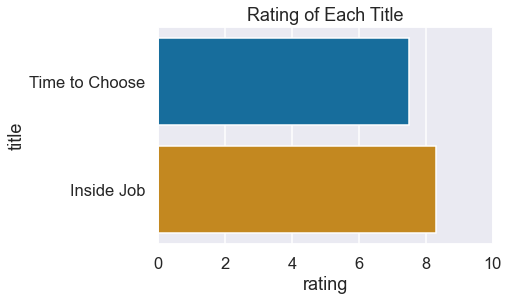

In [369]:
def movie_rate_grapher(name, final_Frame):
    """takes a name and the big data frame and creates a horizontal bar graph 
    for each producer showing the ratings their movies got"""
    
    rating_List =final_Frame['rating_list'].tolist()
    #creats a list of rating
    title_List = final_Frame['title_name'].tolist()
    #creates a list of movie titles
    name_List = final_Frame.index.tolist()
    #creates a lsit of producer nems
    
    
    rating_dict = {name : rating for name, rating in zip(name_List, rating_List)}
    #creates a dictionary with producer names as keys and rating as values
    title_dict = {name : title for name, title in zip(name_List, title_List)}
    #creates a dictionary with producer names as keys and movie titles as values

    rating = rating_dict[name]
    title = title_dict[name]
    #in place values at the dictionary where the name is



    df = pd.DataFrame({'rating' : rating, 'title' : title})
    df = df.rename_axis(name, axis="columns")
    #creates a new data frame containing relevant data to populate graph
    df
    
    #f, ax = plt.subplots(figsize=(10, 10))
    bar = sns.barplot(x = 'rating', y = 'title', data = df, palette="colorblind").set(xlim=(0,10))
    plt.title('Rating of Each Title')
    plt.set_ylabels= ('Each Title Produced')
    plt.set_xlabels=('Rating')
    
    #uses seaborn to create a barplot with the x axis as the ratings and the y axis as the movie titles
    
    return df #returns the dataframe

movie_rate_grapher('Audrey Marrs', final_Frame)

# genre_count_graph
A function that takes a producer name and the final frame and outputs a bar graph showing the count of movies of each genre a producer has produced. The hardest part of this function was splitting up the genre names to get their count as they were much like the title ids from earlier, a list of lists that contain a single string of comma separated words. This function allows us to see graphically which genres each producers has produced the  most work in. this is useful as a metric when combined with Marcos' information on which genres do better in terms of ratings or profit. A consideration to amke when selecting a qualified producer is whether they create popular content in the genre you are intersted in  targeting for your audience or if the genres they do create content in aren't successful in general.

Audrey Marrs,genres,counts
0,Documentary,2
1,Crime,1


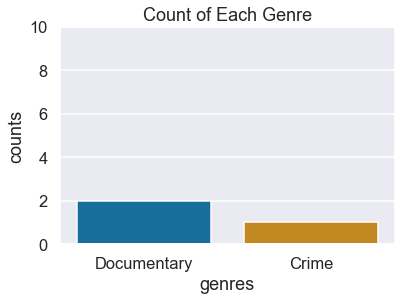

In [370]:
def genre_count_graph(name, finalFrame):
    """Takes in a producer name and outputs a bar graph showing counts of the genres of that each producer produces"""
    flat_genre_List = []
    #creates an empty lsit
    
    name_List = final_Frame.index.tolist()
    #creates a lsit of names from
    genre_Listy = final_Frame['genres'].tolist()
    #creates a list of genres
    #genres are lists of single strings separated by commas
    #strings must be split to collect counts

    
    genre_dict = {name : genre for name, genre in zip(name_List, genre_Listy)}
    #creates a dictionary with the producer name as key adn the list of genres as values
    
    genre = genre_dict[name]
    #creates a list fo genres for desired producer

    
    df1 = pd.DataFrame({'genre' : genre})
    #builds a datafame of idividual producers genre lists
    df1['genre_split'] = df1['genre'].map(lambda x : x.split(','))
    #creates anew column in the dataframe of a list of splits strings
    df1 = df1.drop(['genre'], axis = 1)
    #drops unusable genre column

    
    genre_List = df1['genre_split'].tolist()
    #creates a usable list of genres
    
    for i in genre_List:
        for j in i:
            flat_genre_List.append(j)
    #uses a for loop to get inside the nested list and append each genre found to a flattened list
    

    genre_set = list(set(flat_genre_List))
    #take sthe flattened list and creates a set wrapped in a lsit to get eh unique values
 
    count_dict = {genre:flat_genre_List.count(genre) for genre in flat_genre_List}
    #creates a dictionary where the key is a genre and the value is its count

    
    df = pd.DataFrame({'genres' : list(count_dict.keys()), 'counts' : list(count_dict.values())})
    df = df.rename_axis(name, axis="columns")
    #creates a new dataframe where genres are side by side with their counts but is usabable with seaborn
    
    sns.barplot(x = 'genres', y = 'counts', data = df, palette = "colorblind").set(ylim= (0,10))
    plt.title('Count of Each Genre')
    plt.set_ylabels= ('Counts')
    plt.set_xlabels=('Genres')
    #creates a bar plot with genres as the x axis and teh counts of the genres as the y axis
    
    return df
    



genre_count_graph('Audrey Marrs', final_Frame)

# rating_over_time
a function designed to view the relationship over time of release dates and ratings. THe data is split over years on the x axis with the different color of the poiints illustrating the month the movie was released. This allows us, in conjunction with Svitlana's information about ratings and months to evaluate whether a hgih or low rating when a movie is released might be due to month it was released in. This allows us to evaluate the quality of a producer by taking into consideration average rating might be influenced not by work bu the time it was released.

,rating,year,month
0,5.0,2016,Dec
1,5.2,2015,Feb
2,5.7,2013,Apr


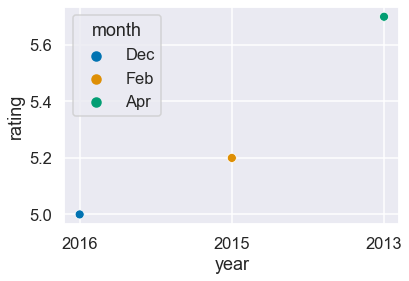

In [371]:
def rating_over_time(name, finalFrame):
    dates_Listy = final_Frame['release_date'].tolist()
    name_List = final_Frame.index.tolist()
    rating_List =final_Frame['rating_list'].tolist()


    
    date_dict = {name : date for name, date in zip(name_List, dates_Listy)}
    #creates a dictionary with the producer name as key adn the list of genres as values
    
    date = date_dict[name]
    #creates a list of dates for desired producer

    
    df1 = pd.DataFrame({'date' : date})
    #builds a datafame of idividual producers date lists
    df1['date_split'] = df1['date'].map(lambda x : x.split(' '))
    #creates a new column in the dataframe of a list of splits strings
    df1 = df1.drop(['date'], axis = 1)
    #drops unusable genre column
    
    dates_List = df1['date_split'].tolist()
    #creates a list of lists of dates separated by spaces like "month, day, year"

    month_List = []
    year_List = []
    #creates an empty list to populate with montha nd year data

    for i in dates_List:
        month_List.append(i[0])
        year_List.append(i[2])
    #uses a for loopto grab just the months and the years

    
    rdict = {name : rating for name, rating in zip(name_List, rating_List)}
    #creates a dictionary 
    ydict = {name : year_List}
    mdict = {name : month_List}


    rating = rdict[name]
    year = ydict[name]
    month = mdict[name]


    
    #x = [*range(1, (len(rating) +1))]
    #print (x)
    
    
    
    df = pd.DataFrame({'rating' : rating, 'year':year, 'month': month})

    sns.scatterplot(data=df, x="year", y="rating", hue = 'month')
    #hue = 'month'
    #sns.lineplot(data=df, x="year", y="rating")
    return df

rating_over_time('Amir Delara', final_Frame)

# SVITLANA

In [372]:
#created a movies_selected dataframe to contain the metrics that are useful to answering my questions
movies_selected = movies[['genre_ids', 'id', 'popularity', 'release_date', 'title', 'vote_average']]

In [373]:
#converted all release_date entries in movies_selected to a new column with datetime objects
movies_selected['release_datetime'] = movies_selected['release_date'].apply(lambda date: datetime.datetime.strptime(date, '%Y-%m-%d'))

In [374]:
#updated movies_selected to be sorted by their release date in descending order from most recent
movies_selected = movies_selected.sort_values('release_datetime', ascending = False)

### Motivation behind choosing 2009 - 2019 time constraints:

Within the last ten years, the climate of media consumption has changed to include a large contribution from streaming services like Netflix and Hulu, and Netflix began creating original content in 2013. In order to have enough data to make meaninful observations, we chose to use data sets for the past decade and to exclude 2020 due to the effects of COVID-19 on theater viewing.  

In [376]:
#created a new dataframe called recent_movies_selected to stay within our constraints of 2009 to 2019

lower_date_limit = datetime.datetime.strptime('2009-01-01', '%Y-%m-%d')
upper_date_limit = datetime.datetime.strptime('2020-01-01', '%Y-%m-%d')

recent_movies_selected = movies_selected.loc[(movies_selected['release_datetime'] > lower_date_limit )
                                             & (movies_selected['release_datetime'] < upper_date_limit)]

#recent_movies_selected.head()

### Selection of movies.csv as the primary source of data  
I chose 'movies.csv' because it provided the most comprehensive data for the information I needed.

Here I created a subset of movie_budgets to observe film release dates and compare them to their worldwide gross income.

In [377]:
#created a subset of movie_budgets 
movie_budgets_selected = movie_budgets[['id', 'release_date', 'movie', 'domestic_gross', 'worldwide_gross', 'production_budget']]


#created two new columns for cleaned gross domestic and gross worldwide values in order to be able to sort by them
movie_budgets_selected['cleaned_ww_gross'] = movie_budgets_selected['worldwide_gross'].apply(lambda x: x.replace('$', '')).apply(lambda x: x.replace(',', '')).astype(np.int64)
movie_budgets_selected['cleaned_domestic_gross'] = movie_budgets_selected['domestic_gross'].apply(lambda x: x.replace('$', '')).apply(lambda x: x.replace(',', '')).astype(np.int64)


#converted productioon_budget values to integers
movie_budgets_selected['cleaned_production_budget'] = movie_budgets_selected['production_budget'].apply(lambda x: x.replace('$', '')).apply(lambda x: x.replace(',', '')).astype(np.int64)

In [378]:
#created a new column for datetime values of the release dates in order to be able to sort and categorize by them

movie_budgets_selected['release_date'] = [date.replace(',', '') for date in movie_budgets_selected['release_date']]
movie_budgets_selected['release_datetime'] = movie_budgets_selected['release_date'].apply(lambda date: datetime.datetime.strptime(date, '%b %d %Y'))

In [379]:
#movie_budgets_selected.head()

I was unsure of whether I wanted to keep a backup dataframe with the information as is so I created a new one titled titled  
movie_budgets_date to keep a date-sorted one on hand.

In [380]:
#movie_budgets dataframe sorted by oldest release first
movie_budgets_date = movie_budgets_selected.sort_values('release_datetime')

To operate within our constraints, I set an upper and lower date limit to subset the dataframe.

In [381]:
#subset of movie_budgets_date sorted by release date and between the years 2009 and 2019

lower_date_limit = datetime.datetime.strptime('2009-01-01', '%Y-%m-%d')
upper_date_limit = datetime.datetime.strptime('2020-01-01', '%Y-%m-%d')

recent_movie_budgets = movie_budgets_date.loc[(movie_budgets_date['release_datetime'] > lower_date_limit )
                                             & (movie_budgets_date['release_datetime'] < upper_date_limit)]

I wanted to observe the frequency of films being released during certain times of the year and see if there was any correlation.  
Q1: January - March  
Q2: April - June  
Q3: July - September  
Q4: October - December  

In [382]:
#added a 'quarter' category to be able to categorize films by the quarter during which they were released

recent_movie_budgets['quarter'] = [datetime.to_period('Q') for datetime in recent_movie_budgets['release_datetime']]

To get a more granular view, I also added a category that would isolate the specific release month for each film as well.

In [383]:
#added a 'release_month' category to be able to count releases by their months
recent_movie_budgets['release_month'] = [date.month for date in recent_movie_budgets['release_datetime']]

In [267]:
recent_movie_budgets

,id,release_date,movie,domestic_gross,worldwide_gross,production_budget,cleaned_ww_gross,cleaned_domestic_gross,cleaned_production_budget,release_datetime,quarter,release_month
4318,19,Jan 9 2009,Not Easily Broken,"$10,572,742","$10,732,909","$5,000,000",10732909,10572742,5000000,2009-01-09,2009Q1,1
1880,81,Jan 9 2009,Bride Wars,"$58,715,510","$115,150,424","$30,000,000",115150424,58715510,30000000,2009-01-09,2009Q1,1
2934,35,Jan 9 2009,The Unborn,"$42,670,410","$78,208,812","$16,000,000",78208812,42670410,16000000,2009-01-09,2009Q1,1
3179,80,Jan 16 2009,My Bloody Valentine,"$51,545,952","$102,836,002","$14,000,000",102836002,51545952,14000000,2009-01-16,2009Q1,1
1164,65,Jan 16 2009,Defiance,"$28,644,813","$52,987,754","$50,000,000",52987754,28644813,50000000,2009-01-16,2009Q1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
3515,16,Dec 31 2019,Eli,$0,$0,"$11,000,000",0,0,11000000,2019-12-31,2019Q4,12
671,72,Dec 31 2019,355,$0,$0,"$75,000,000",0,0,75000000,2019-12-31,2019Q4,12
1543,44,Dec 31 2019,Down Under Cover,$0,$0,"$40,000,000",0,0,40000000,2019-12-31,2019Q4,12
2329,30,Dec 31 2019,Reagan,$0,$0,"$25,000,000",0,0,25000000,2019-12-31,2019Q4,12


In [384]:
#experimenting with grouping by quarter
recent_movie_budgets['q'] = recent_movie_budgets['quarter'].apply(lambda x: str(x)[-1])

In [385]:
recent_movie_budgets.sort_values('cleaned_domestic_gross', ascending = False)

,id,release_date,movie,domestic_gross,worldwide_gross,production_budget,cleaned_ww_gross,cleaned_domestic_gross,cleaned_production_budget,release_datetime,quarter,release_month,q
5,6,Dec 18 2015,Star Wars Ep. VII: The Force Awakens,"$936,662,225","$2,053,311,220","$306,000,000",2053311220,936662225,306000000,2015-12-18,2015Q4,12,4
0,1,Dec 18 2009,Avatar,"$760,507,625","$2,776,345,279","$425,000,000",2776345279,760507625,425000000,2009-12-18,2009Q4,12,4
41,42,Feb 16 2018,Black Panther,"$700,059,566","$1,348,258,224","$200,000,000",1348258224,700059566,200000000,2018-02-16,2018Q1,2,1
6,7,Apr 27 2018,Avengers: Infinity War,"$678,815,482","$2,048,134,200","$300,000,000",2048134200,678815482,300000000,2018-04-27,2018Q2,4,2
33,34,Jun 12 2015,Jurassic World,"$652,270,625","$1,648,854,864","$215,000,000",1648854864,652270625,215000000,2015-06-12,2015Q2,6,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5472,73,Apr 3 2012,Enter Nowhere,$0,$0,"$500,000",0,0,500000,2012-04-03,2012Q2,4,2
5732,33,Mar 31 2012,Foreign Letters,$0,$0,"$40,000",0,0,40000,2012-03-31,2012Q1,3,1
3311,12,Mar 30 2012,Womb,$0,$0,"$13,000,000",0,0,13000000,2012-03-30,2012Q1,3,1
5115,16,Nov 20 2015,#Horror,$0,$0,"$1,500,000",0,0,1500000,2015-11-20,2015Q4,11,4


There were some movies that did not have adequate budget information to use in the data set, so I updated it to only include those with at least a worldwide gross - this accounted for about 290 rows of data out of approximately 2400, reducing it to just over 2100 rows.

In [387]:
#removed any entries with $0 worldwide gross
recent_movie_budgets = recent_movie_budgets[recent_movie_budgets['cleaned_ww_gross'] > 0]

I also dropped the id column, because it did not seem to correlate with any of the other ids in the features we chose to analyse.

In [388]:
#dropped id column 
recent_movie_budgets.drop('id', axis = 1, inplace = True)

To examine actual profit of films, I created a new column to calculate net income. 

In [390]:
#added a net_income column to calculate gross income minus production budget
recent_movie_budgets['net_income'] = recent_movie_budgets['cleaned_ww_gross'] - recent_movie_budgets['cleaned_production_budget']

#recent_movie_budgets.head()

### Dataframe to construct visualizations of worldwide gross income by month and by quarter and of release frequencies by month and by quarter

For consistency and ease of labeling, I subset my dataframes for the metrics I wanted to compare. 

In [391]:
#subsetting worldwide gross mean by month and by quarter
worldwidegross_q = recent_movie_budgets[['q','cleaned_ww_gross']].groupby('q').mean()


worldwidegross_m = recent_movie_budgets[['release_month','cleaned_ww_gross']].groupby('release_month').mean()

## Seaborn visualizations using worldwidegross parameters

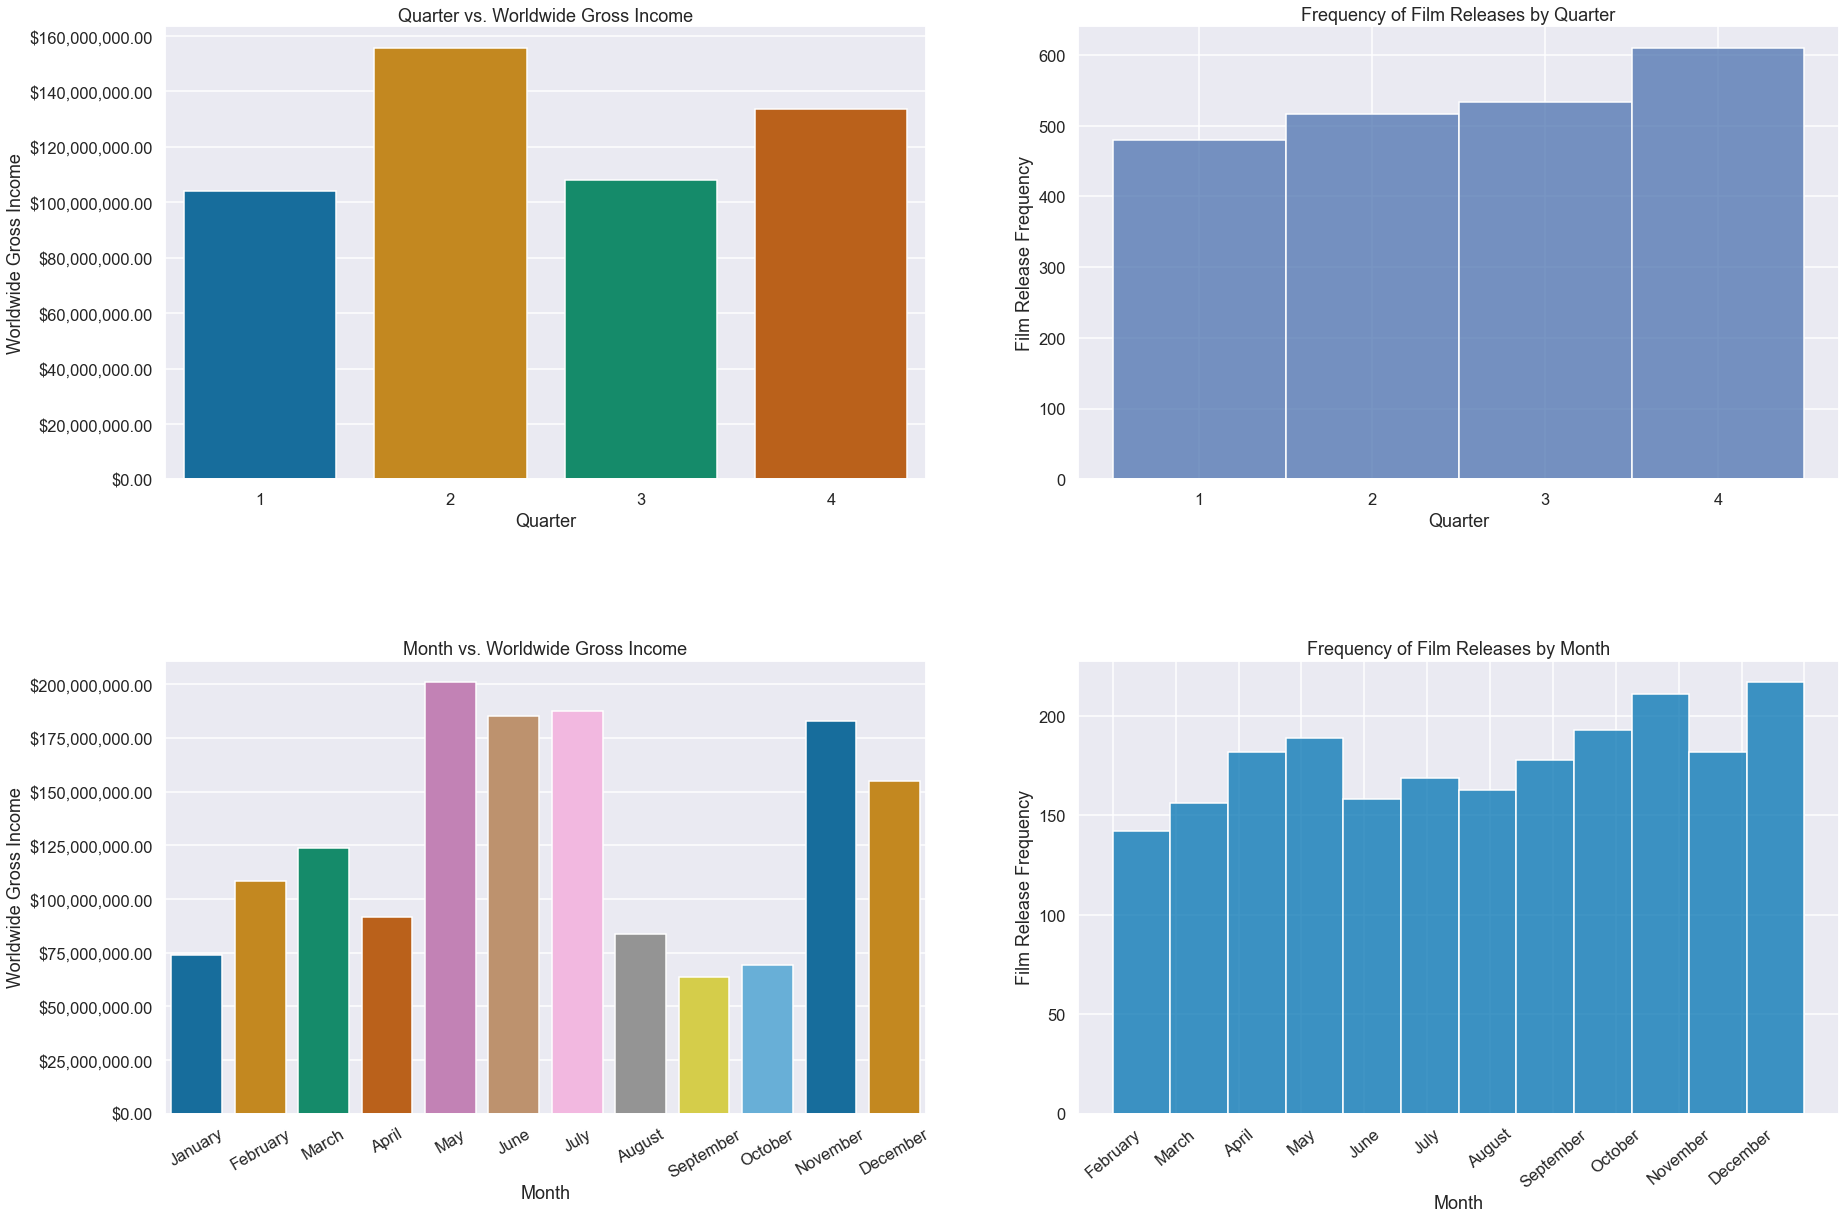

In [392]:
#seaborn visualization of quarters versus worldwide_gross

fig, axes = plt.subplots( 2, 2, figsize = (30,20))
sns.set_theme()
sns.set_context('talk')
plt.subplots_adjust(hspace = .4)

#setting y axis formatting to include $ and comma-separation
formatter = ticker.FuncFormatter(lambda x, p: '${:,.2f}'.format(x))

#hardcode for label strings
month_labels = ['January', 'February', 'March', 'April','May', 'June', 'July', 'August', 'September', 'October', 'November',  'December']

#x and y values for gross income plots
#x values
annual_quarters = worldwidegross_q.index
months = worldwidegross_m.index
#y values
worldwidegross_quarters = worldwidegross_q['cleaned_ww_gross']
worldwidegross_months = worldwidegross_m['cleaned_ww_gross']


#x and data values for frequency plots
#x values
quarters_freq = recent_movie_budgets['q']
months_freq = recent_movie_budgets['release_month']

#data values
release_frequency_q = recent_movie_budgets['q'].value_counts()
release_frequency_m = recent_movie_budgets['release_month'].value_counts()



#Plot 1 [0,0]
sns.barplot(ax = axes[0,0], x = annual_quarters, y = worldwidegross_quarters, palette = 'colorblind')
axes[0,0].set(xlabel="Quarter", ylabel="Worldwide Gross Income")
axes[0,0].set_title("Quarter vs. Worldwide Gross Income")
axes[0,0].yaxis.set_major_formatter(formatter)


#Plot 2 [0,1]
sns.histplot(ax = axes[0,1], data = release_frequency_q, x = quarters_freq, bins = 4)
axes[0,1].set_title("Frequency of Film Releases by Quarter")
axes[0,1].set(xlabel = "Quarter", ylabel = "Film Release Frequency")

#Plot 3 [1,0]
sns.barplot(ax = axes[1,0], x = months, y = worldwidegross_months, palette = 'colorblind')
sns.set_palette('colorblind')
axes[1,0].set(xlabel="Month", ylabel="Worldwide Gross Income")
axes[1,0].set_title("Month vs. Worldwide Gross Income")
axes[1,0].set_xticklabels(month_labels, rotation = 30)
axes[1,0].yaxis.set_major_formatter(formatter)


#Plot 4 [1,1]
sns.histplot(ax = axes[1,1], data = release_frequency_m , x = months_freq , bins = 12)
axes[1,1].set_title("Frequency of Film Releases by Month")
axes[1,1].set(xlabel = "Month", ylabel = "Film Release Frequency")
axes[1,1].xaxis.set_major_locator(ticker.MultipleLocator(1))
axes[1,1].xaxis.set_major_formatter(ticker.ScalarFormatter())
axes[1,1].set_xticklabels(month_labels, rotation = 40);


Observing the two graphs that track income and release frequency by month, it appears that May through July are the most profitable while October through December see the most films being released. I chose to narrow in on those months to compare film gross versus film production budgets to determine average net incomes.  
Here, I also subset the data to only use the metrics I want to compare.

In [393]:
##subsets of movie_budgets grouped by season to isolate only net_income mean

##movie information for May-July stored as summer_budgets
summer_budgets = recent_movie_budgets.loc[(recent_movie_budgets['release_month']).isin([5,6,7])] 
summer_budgets = summer_budgets[['release_month','net_income']].groupby('release_month').mean()

##movie information for October-December stored as fall_budgets
fall_budgets = recent_movie_budgets.loc[(recent_movie_budgets['release_month']).isin([10,11,12])]
fall_budgets = fall_budgets[['release_month','net_income']].groupby('release_month').mean()

From here, I took this data and generated one net income graph for each of the selected timeframes.

[Text(0, 0, 'October'), Text(1, 0, 'November'), Text(2, 0, 'December')]

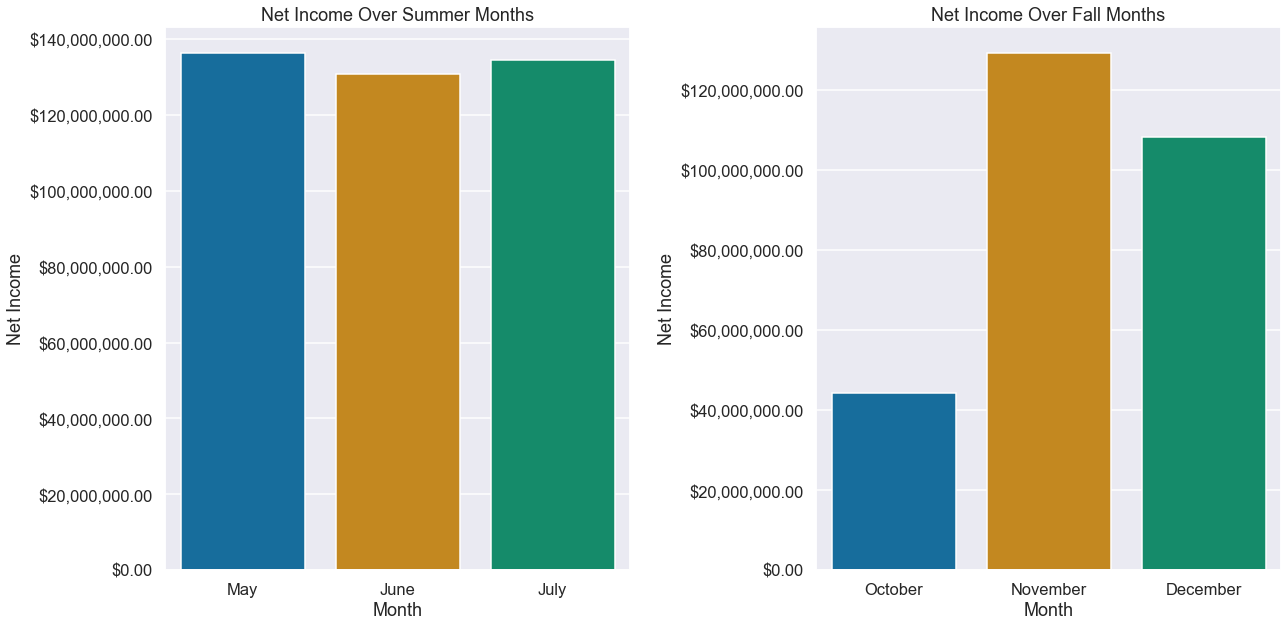

In [394]:
#plotting two graphs to compare net_income for the selected months

fig, axes = plt.subplots( 1,2, figsize = (20,10))
plt.subplots_adjust(wspace = .4)

#set variables for summer and fall datasets
summer_net = summer_budgets['net_income']
summer_months = summer_budgets.index

fall_net = fall_budgets['net_income']
fall_months = fall_budgets.index

#Plot 1 [0]
sns.barplot(ax = axes[0], x = summer_months, y = summer_net, palette = 'colorblind')
axes[0].yaxis.set_major_formatter(formatter)
axes[0].set(xlabel="Month", ylabel="Net Income")
axes[0].set_title("Net Income Over Summer Months")
axes[0].set_xticklabels(['May', 'June', 'July'])

#Plot 2 [1]
sns.barplot(ax = axes[1], x = fall_months, y = fall_net, palette = 'colorblind')
axes[1].yaxis.set_major_formatter(formatter)
axes[1].set(xlabel="Month", ylabel="Net Income")
axes[1].set_title("Net Income Over Fall Months")
axes[1].set_xticklabels(['October', 'November', 'December'])

In [395]:
#created some data sets to measure gross and net income over quarters and months

monthly_net = recent_movie_budgets[['release_month','net_income']].groupby('release_month').mean()
quarter_net = recent_movie_budgets[['q', 'net_income']].groupby('q').mean()

I was interested in seeing if there was any correlation or connection with the most profitable months and months with lower frequencies of film releases, so I decided to generate a scatter plot that measured frequency (x-axis), net income (y-axis) and denoted where each month fell by using a different colored plot point.

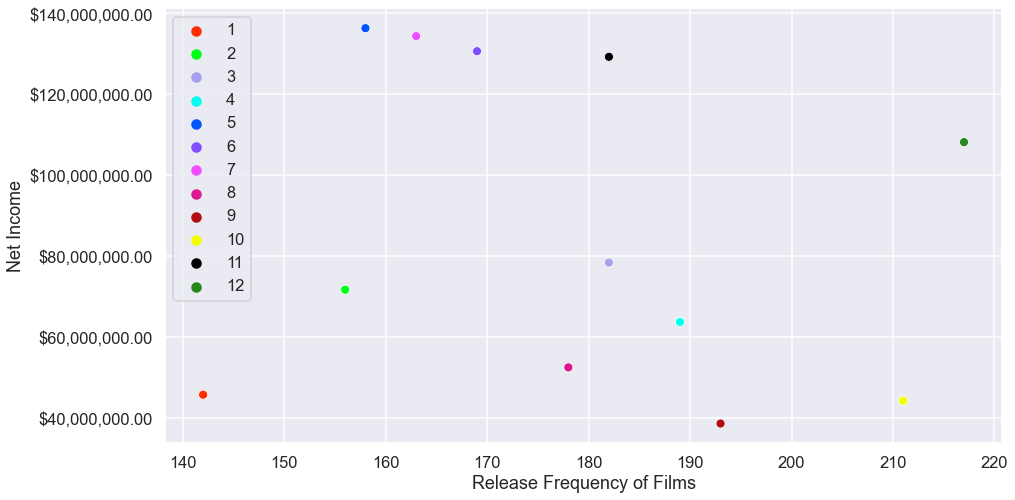

In [396]:
fig, ax = plt.subplots(figsize = (15,8))
#to make each month different, I created my own palette
colors = ['#FF2D00','#00FF17','#A6A0EF','#00FFF0','#0055FF','#814EFF','#EF4EFF','#DC168E','#B20D12','#F3FF00','#000000','#27871A']


graph = sns.scatterplot(x = release_frequency_m, y = monthly_net['net_income'], hue = monthly_net.index, palette = colors, legend = 'full')
ax.yaxis.set_major_formatter(formatter)
ax.set(xlabel = 'Release Frequency of Films', ylabel = 'Net Income')
#legend formatting
ax.legend()


The scatter plot supports that summer months are some of the most profitable months for film releases. November can also be observed as a successful month based on these metrics.  

Below, I wanted to check net income per month for the entire year and it seems to correlate exactly with gross income.

[Text(0, 0, 'January'),
 Text(1, 0, 'February'),
 Text(2, 0, 'March'),
 Text(3, 0, 'April'),
 Text(4, 0, 'May'),
 Text(5, 0, 'June'),
 Text(6, 0, 'July'),
 Text(7, 0, 'August'),
 Text(8, 0, 'September'),
 Text(9, 0, 'October'),
 Text(10, 0, 'November'),
 Text(11, 0, 'December')]

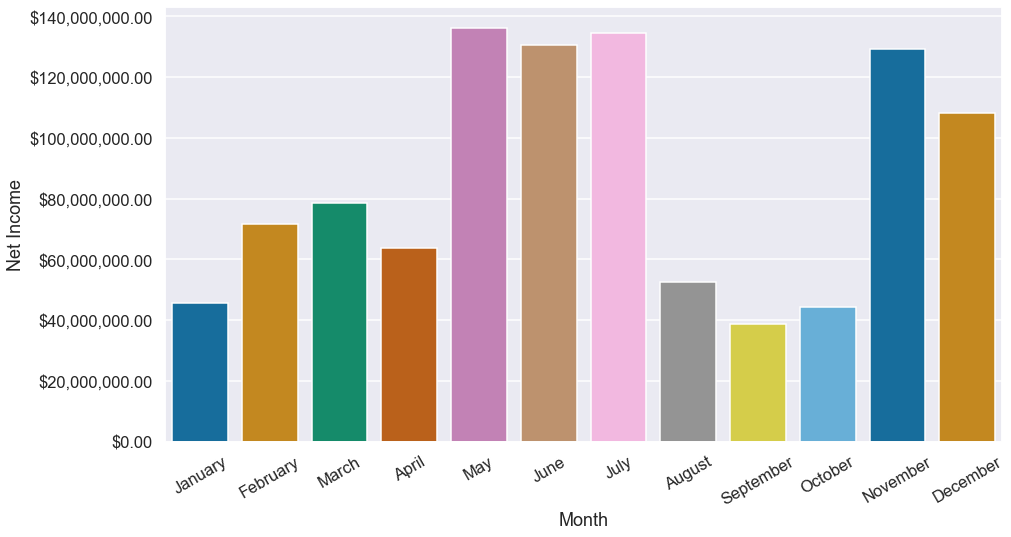

In [397]:
fig, ax = plt.subplots(figsize = (15,8))

sns.barplot(x = monthly_net.index, y = monthly_net['net_income'], palette = 'colorblind')
ax.yaxis.set_major_formatter(formatter)
ax.set(xlabel = 'Month', ylabel = 'Net Income')
ax.set_xticklabels(month_labels, rotation = 30)

A bonus graph of net income by quarter, since that's where I started.

[Text(0.5, 0, 'Quarter'), Text(0, 0.5, 'Net Income')]

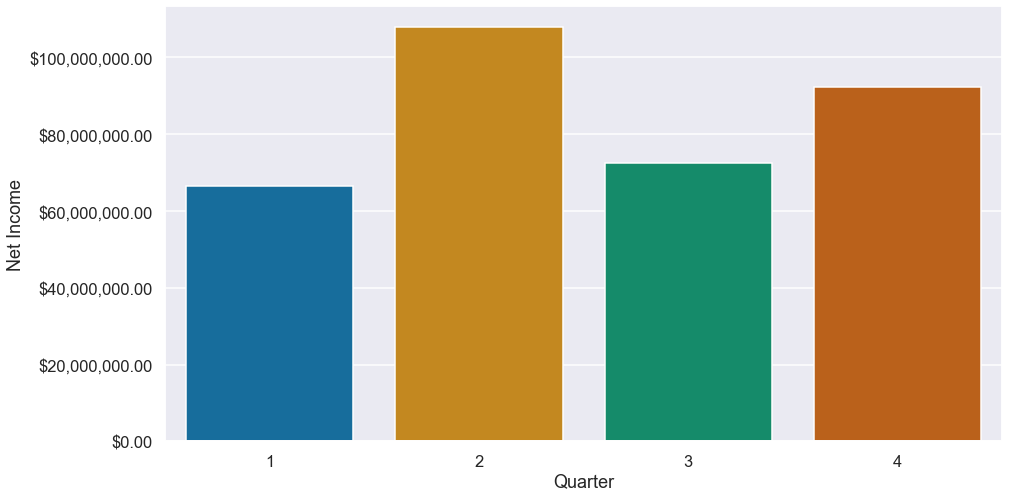

In [398]:
fig, ax = plt.subplots(figsize = (15,8))
sns.barplot(x = quarter_net.index, y = quarter_net['net_income'], palette = 'colorblind')
ax.yaxis.set_major_formatter(formatter)
ax.set(xlabel = 'Quarter', ylabel = 'Net Income')

## Evaluation  

### Recommendations for Film Producers  
-  

### Recommendations for Genres of Films  
-

### Recommendations for Release Dates  
-


## Conclusion
This data can be useful to finetune selections based on individual budget, staffing, and style limitations. 

Our recommendations look to minimize budget and maximize net income but depending on individual goals, the information allows to explore other intersections.
